In [39]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import KDTree
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import pandas as pd

In [40]:
def whiten(x):
    # center the data:
    x = x - x.mean(axis=1)[:, np.newaxis]
    # calculate the inverse squareroot of the covariance to whiten with
    S = x @ x.T / (x.shape[1] - 1)
    L_s, Q_s = np.linalg.eigh(S)
    W = Q_s @ np.diag(1 / (L_s)**0.5) @ Q_s.T
    return W @ x, W, Q_s @ np.diag((L_s)**0.5) @ Q_s.T

In [41]:
def objective(M,G):
    r = 0
    for j in range(M.shape[0]):
        r += (np.tensordot(G[j,:], M, axes=([0],[0])) @ G[j,:])**2
    return r
    #return np.sum(np.einsum("ji,ikl,jl->jk", G, M, G)**2)

## diagonalize
def diagonalize(M, max_iters=10_000, gamma=0.001):
    G = np.eye(M.shape[0])
    old_G = G.copy()
    for i in range(max_iters):
        # gradient descent on each column
        for j in range(M.shape[0]):
            G[j,:] = G[j,:] + 4* gamma * np.tensordot(G[j,:], M, axes=([0],[0])) @ G[j,:] @ (M @ G[j,:]).T
        # orthogonalize
        U, Sigma, V = np.linalg.svd(G)
        G = U @ V.T
        if np.linalg.norm(G-old_G,'fro')/np.linalg.norm(G,'fro') < 1e-8:
            print(f"Convergence reached after {i} iterations!")
            break
        old_G = G.copy()
    return G

def SOBIsym(M, max_iters=10_000,):
    G = np.eye(M.shape[0])
    old_G = G.copy()
    for i in range(max_iters):
        # gradient descent on each column
        for j in range(M.shape[0]):
            G[j,:] = np.tensordot(G[j,:], M, axes=([0],[0])) @ G[j,:] @ (M @ G[j,:]).T
        # orthogonalize
        U, Sigma, V = np.linalg.svd(G)
        G = U @ V.T
        if np.linalg.norm(G-old_G,'fro')/np.linalg.norm(G,'fro') < 1e-8:
            print(f"Convergence reached after {i} iterations!")
            break
        old_G = G.copy()
    return G

In [42]:
def calculate_local_covariance(points, radius, variables):
    """
    Calculates the covariance matrix for points within a certain radius for each point.

    Args:
        points (np.ndarray): A NumPy array of shape (N, D) where N is the number of
                             points and D is the dimension (e.g., 3 for 3D points).
        radius (float): The radius within which to search for neighbors.
        variables (np.ndarray): a NumPy array of shape (N, P) where P is the dimension
                            of the variables

    Returns:
        np.ndarray: PxP matrix of the covariance
    """
    # Build a KD-Tree for efficient spatial searching
    tree = KDTree(points)
    
    # List to store the covariance matrix for each point
    covariance_matrix = np.zeros((variables.shape[1], variables.shape[1]))
    total_neighbors = 0
    # Iterate over each point
    for i, query_point in enumerate(points):
        # Find indices of points within the specified radius
        neighbor_indices = tree.query_ball_point(query_point, radius)
        total_neighbors += len(neighbor_indices)

        # Select the neighboring points
        neighbors = variables[neighbor_indices] 
        covariance_matrix += np.outer(neighbors.sum(axis=0) / variables.shape[0]**0.5, variables[i])
    Fn = total_neighbors
    return covariance_matrix / (Fn**0.5)

# Simulation

### Generate and Preprocess

The spatial correlation is attained by using Gaussian Processes with Matern correlation.

In [43]:
np.random.seed(15)
p = 3
n = 2000
# locations of observations (1x1 square domain)
s = np.random.rand(n,2)

In [44]:
def matern_correlation(distances, nu, length_scale):
    """
    Calculates the Matern correlation function.

    Args:
        distances (np.ndarray): A 1D array of distances between points.
        nu (float): The smoothness parameter of the Matern kernel.
                    Common values are 0.5, 1.5, 2.5, or infinity (for RBF kernel).
        length_scale (float): The characteristic length scale of the correlation.

    Returns:
        np.ndarray: A 1D array of Matern correlation values.
    """
    if nu == 0.5:
        # Exponential kernel (Matern with nu=0.5)
        return np.exp(-distances / length_scale)
    elif nu == 1.5:
        # Matern with nu=1.5
        scaled_dist = distances / length_scale
        return (1 + np.sqrt(3) * scaled_dist) * np.exp(-np.sqrt(3) * scaled_dist)
    elif nu == 2.5:
        # Matern with nu=2.5
        scaled_dist = distances / length_scale
        return (1 + np.sqrt(5) * scaled_dist + 5/3 * scaled_dist**2) * np.exp(-np.sqrt(5) * scaled_dist)
    elif np.isinf(nu):
        # Radial Basis Function (RBF) or Squared Exponential kernel (Matern with nu=infinity)
        return np.exp(-0.5 * (distances / length_scale)**2)
    else:
        # General Matern kernel (requires special functions from scipy.special)
        from scipy.special import kv, gamma
        scaled_dist = distances / length_scale
        # Handle the case where scaled_dist is zero to avoid division by zero in kv
        # and ensure correlation is 1 at zero distance.
        correlation = np.zeros_like(scaled_dist)
        non_zero_indices = scaled_dist > 1e-10 # Small epsilon to avoid exact zero
        
        correlation[non_zero_indices] = (2**(1-nu) / gamma(nu)) * \
                                        (np.sqrt(2*nu) * scaled_dist[non_zero_indices])**nu * \
                                        kv(nu, np.sqrt(2*nu) * scaled_dist[non_zero_indices])
        correlation[~non_zero_indices] = 1.0 # Correlation is 1 at zero distance
        return correlation

In [45]:
# Calculate pairwise distances between points
distances = pdist(s, 'euclidean') # Calculates distances in a condensed form
D = squareform(distances) # Converts to a square matrix

K1 = matern_correlation(D, 6, 1.2)
K2 = matern_correlation(D, 1, 1.5)
K3 = matern_correlation(D, 0.25, 1)
z = np.stack([
    np.random.multivariate_normal(np.zeros(n), K1),
    np.random.multivariate_normal(np.zeros(n), K2),
    np.random.multivariate_normal(np.zeros(n), K3)])

In [46]:
# mixing matrix
O = np.random.normal(size=(p,p))
x = O @ z

In [47]:
O

array([[-0.44763045,  0.96467246, -1.85360558],
       [ 0.04094633, -0.79126704,  1.36363663],
       [-0.2680828 ,  0.64470477,  0.25599788]])

In [48]:
np.savetxt('mixture.csv', x.T, delimiter=',')
np.savetxt('coords.csv', s, delimiter=',') 

In [49]:
xt, W, W_inv = whiten(x)

In [50]:
# xt is whitened
np.cov(xt)

array([[ 1.00000000e+00,  1.66341289e-14, -2.16424066e-15],
       [ 1.66341289e-14,  1.00000000e+00, -5.06692681e-15],
       [-2.16424066e-15, -5.06692681e-15,  1.00000000e+00]])

### Join Diagonalize Local Covariance Matrices

Using SOBIsym optimizaiton (projected gradient descent)

In [51]:
# calculate local covariance matrices
M30 = calculate_local_covariance(s, 0.3, xt.T)
M10 = calculate_local_covariance(s, 0.1, xt.T)
M05 = calculate_local_covariance(s, 0.05, xt.T)
M01 = calculate_local_covariance(s, 0.01, xt.T)
M = np.stack((M30, M10, M05, M01), axis=1)

In [16]:
from qndiag import qndiag
G, rslts = qndiag(np.transpose(M, (1, 0, 2)), ortho=True)

In [52]:
G = SOBIsym(M)
objective(M,G)

Convergence reached after 47 iterations!


array([290.32566543,  91.96819731,  31.69789217,   4.65671225])

In [53]:
# off-diagonals are minimized
G @ M30 @ G.T, G @ M10 @ G.T, G @ M05 @ G.T, G @ M01 @ G.T

(array([[ 8.49668301, -0.09887446,  1.64961801],
        [-0.09887446,  1.92571984,  0.29885221],
        [ 1.64961801,  0.29885221, 14.64321161]]),
 array([[5.90799447, 0.09962634, 0.26334403],
        [0.09962634, 2.82411525, 0.0709315 ],
        [0.26334403, 0.0709315 , 7.00629515]]),
 array([[ 3.53868064, -0.01693716,  0.05402038],
        [-0.01693716,  2.14636824,  0.03788999],
        [ 0.05402038,  0.03788999,  3.81690121]]),
 array([[1.25471173, 0.01563697, 0.02191426],
        [0.01563697, 1.18274768, 0.02275198],
        [0.02191426, 0.02275198, 1.29750478]]))

In [54]:
# Show that the optimization is affine invariant
# calculate local covariance matrices
M30_ = calculate_local_covariance(s, 0.3, x.T)
M10_ = calculate_local_covariance(s, 0.1, x.T)
M05_ = calculate_local_covariance(s, 0.05, x.T)
M01_ = calculate_local_covariance(s, 0.01, x.T)

In [55]:
G @ W  @ M30_ @ W @ G.T, G @ W @ M10_ @ W @ G.T, G @ W @ M05_ @ W @ G.T, G @ W @ M01_ @ W @ G.T

(array([[142.62510765, -49.41052676, 169.51862515],
        [-49.41052676,  19.95916463, -61.21767284],
        [169.51862515, -61.21767284, 224.32390604]]),
 array([[ 53.97774437, -18.34723042,  61.36336962],
        [-18.34723042,   9.89771969, -23.35785111],
        [ 61.36336962, -23.35785111,  84.60569639]]),
 array([[ 28.20173439,  -9.63229719,  31.82086972],
        [ -9.63229719,   5.89460113, -12.34488725],
        [ 31.82086972, -12.34488725,  44.72454665]]),
 array([[ 9.0084386 , -3.0267717 , 10.11841967],
        [-3.0267717 ,  2.37649806, -3.93883772],
        [10.11841967, -3.93883772, 14.44445225]]))

In [56]:
# G is orthogonal
G @ G.T

array([[ 1.00000000e+00, -4.93919194e-17,  2.07553558e-16],
       [-4.93919194e-17,  1.00000000e+00,  1.09165022e-17],
       [ 2.07553558e-16,  1.09165022e-17,  1.00000000e+00]])

### Examine at Performance

In [57]:
from scipy.optimize import linear_sum_assignment

def MDI(G):
    Gt = G**2 / (np.linalg.norm(G, axis=1)**2)[:, np.newaxis]
    cost = np.ones_like(Gt) - 2*Gt - (Gt**2).sum(axis=1)[:, np.newaxis]
    row_ind, col_ind = linear_sum_assignment(cost, maximize=False)
    perm = np.argsort(col_ind)
    return (G.shape[0] - (Gt[row_ind, col_ind]).sum())**0.5 / (G.shape[0] - 1)**0.5

In [58]:
MDI(G @ W @ O)

np.float64(0.5510313497069279)

In [59]:
(G @ W) @ O

array([[ 0.66412722,  4.4894807 , -0.01495025],
       [ 1.58147722,  0.29727572, -1.7783715 ],
       [-2.52873006, -0.99761002, -0.09204545]])

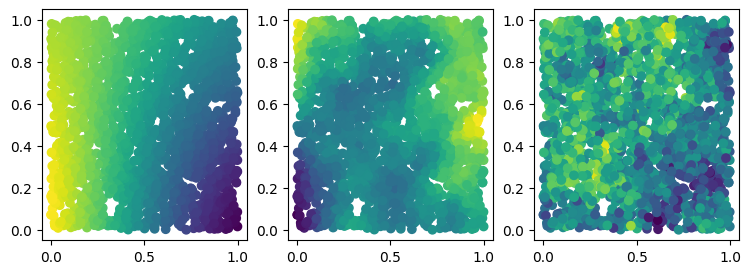

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

# Plot on the first subplot (top-left)
axs[0].scatter(s.T[0], s.T[1], c = z[0])
axs[1].scatter(s.T[0], s.T[1], c = z[1])
axs[2].scatter(s.T[0], s.T[1], c = z[2])
plt.show()

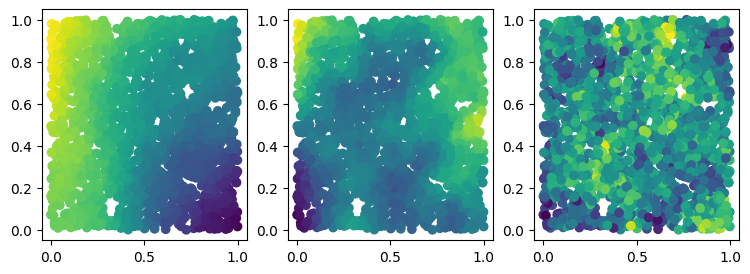

In [61]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

# Plot on the first subplot (top-left)
axs[0].scatter(s.T[0], s.T[1], c = -1*zt[2])
axs[1].scatter(s.T[0], s.T[1], c = zt[0])
axs[2].scatter(s.T[0], s.T[1], c = -1*zt[1])
plt.show()

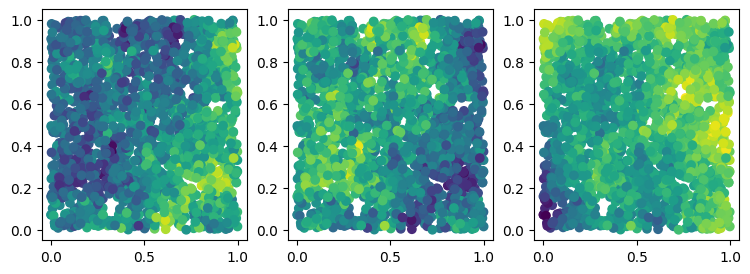

In [62]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

# Plot on the first subplot (top-left)
axs[0].scatter(s.T[0], s.T[1], c = x[0])
axs[1].scatter(s.T[0], s.T[1], c = x[1])
axs[2].scatter(s.T[0], s.T[1], c = x[2])
plt.show()

# KOLA

In [32]:
def helmert_basis(D: int) -> np.ndarray:
    """
    Orthonormal Helmert basis for the Aitchison simplex (D x (D-1)).
    Column j (0-based) corresponds to contrast of first j+1 parts vs part j+2.
    """
    if D < 2:
        raise ValueError("D must be >= 2")
    B = np.zeros((D, D - 1), dtype=float)
    for j in range(1, D):  # j = 1..D-1
        v = np.zeros(D, dtype=float)
        v[:j] = 1.0 / j
        v[j] = -1.0
        v *= np.sqrt(j / (j + 1))
        B[:, j - 1] = v
    return B

def ilr(x: np.ndarray, basis: np.ndarray | None = None, eps: float | None = None) -> np.ndarray:
    """
    ILR transform of compositional data.
    x: (..., D) array of positive compositions (not necessarily closed). Rows are compositions.
    basis: optional D x (D-1) orthonormal basis (default: Helmert).
    eps: if provided, non-positive entries are replaced by eps (useful for zeros).
    Returns: (..., D-1) ilr coordinates.
    """
    x = np.asarray(x, dtype=float)
    if x.ndim == 1:
        x = x.reshape(1, -1)
        _squeeze = True
    else:
        _squeeze = False
    if np.any(x <= 0):
        if eps is None:
            raise ValueError("Compositions must be positive; pass eps to replace zeros/non-positives.")
        x = np.where(x <= 0, eps, x)
    D = x.shape[-1]
    if basis is None:
        basis = helmert_basis(D)
    if basis.shape != (D, D - 1):
        raise ValueError("basis must have shape (D, D-1)")
    logx = np.log(x)
    logx = logx - logx.mean(axis=0)
    # contract last axis of logx with first axis of basis -> (..., D-1)
    y = np.tensordot(logx, basis, axes=([logx.ndim - 1], [0]))
    return y[0] if _squeeze else y

def ilr_inv(y: np.ndarray, basis: np.ndarray | None = None) -> np.ndarray:
    """
    Inverse ILR: from ilr coords (..., D-1) back to compositions (..., D) (closed to sum 1).
    basis: optional D x (D-1) orthonormal basis (default: Helmert).
    """
    y = np.asarray(y, dtype=float)
    if y.ndim == 1:
        y = y.reshape(1, -1)
        _squeeze = True
    else:
        _squeeze = False
    D_minus_1 = y.shape[-1]
    D = D_minus_1 + 1
    if basis is None:
        basis = helmert_basis(D)
    if basis.shape != (D, D - 1):
        raise ValueError("basis must have shape (D, D-1)")
    # clr = V @ y for each sample -> use matrix multiply: y (..., D-1) @ basis.T ((D-1), D)
    clr = y @ basis.T
    exp_clr = np.exp(clr)
    comp = exp_clr / np.sum(exp_clr, axis=-1, keepdims=True)
    return comp[0] if _squeeze else comp

In [210]:
moss = pd.read_csv('moss.csv')

In [211]:
moss

,Unnamed: 0,ID,XCOO,YCOO,ELEV,COUN,ASP,GENLAN,TOPO,GROUNDVEG,...,Sc,Se,Si,Sr,Th,Tl,U,V,Y,Zn
0,1,1,547960.4,7693790,135,FIN,NW,FLA PLAIN,CONCLOW,EMPETRUM,...,0.05,0.4,78.9,5.61,0.007,0.022,0.007,0.53,0.05,29.3
1,2,2,770024.8,7679167,140,RUS,SW,RIDGE,CONVLOW,SHRUBS,...,0.05,0.4,230.0,12.20,0.028,0.025,0.013,9.92,0.10,34.1
2,3,3,498650.6,7668151,255,FIN,N,PLAIN,CONC,BLUEBERRY,...,0.05,0.4,110.0,9.97,0.013,0.018,0.005,1.12,0.05,59.1
3,4,4,795151.9,7569386,240,RUS,NE,RIDGE,UPBRLOW,WHITE_LICHEN,...,0.05,0.4,268.0,17.60,0.046,0.046,0.023,3.13,0.20,33.5
4,5,5,437050.0,7855900,80,NOR,N,LOWMO,CONCLOW,SHRUBS,...,0.05,0.4,347.0,26.00,0.202,0.027,0.136,0.98,0.90,20.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,590,902,657495.1,7742796,90,RUS,NE,DEEPVAL,CONCLOW,LICHEN,...,0.05,0.4,299.0,13.20,0.020,0.018,0.015,2.72,0.05,28.5
590,591,903,685681.5,7741352,170,RUS,N,RIDGE,CONCLOW,LICHEN,...,0.05,0.4,262.0,9.98,0.034,0.016,0.016,1.70,0.05,20.3
591,592,904,683207.4,7730755,180,RUS,E,DEEPVAL,UPBRLOW,MOSS,...,0.05,0.4,199.0,23.50,0.026,0.018,0.028,1.48,1.30,20.5
592,593,905,680047.2,7720995,200,RUS,SW,RIDGE,TOPUPBR,LICHEN,...,0.05,0.4,268.0,8.73,0.027,0.014,0.013,3.18,0.05,40.8


In [212]:
s = moss[['XCOO','YCOO']].values
x = moss[['Ag', 'Al', 'As', 'Au', 'B',
       'Ba', 'Be', 'Bi', 'Ca', 'Cd', 'Co', 'Cr', 'Cu', 'Fe', 'Hg', 'K', 'La',
       'Mg', 'Mn', 'Mo', 'Na', 'Ni', 'P', 'Pb', 'Pd', 'Pt', 'Rb', 'S', 'Sb',
       'Sc', 'Se', 'Si', 'Sr', 'Th', 'Tl', 'U', 'V', 'Y', 'Zn']].fillna(0).values

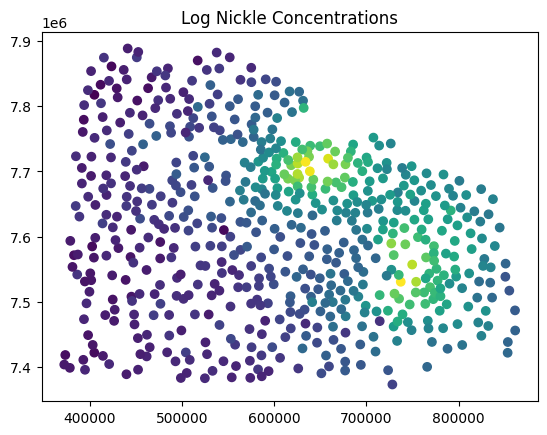

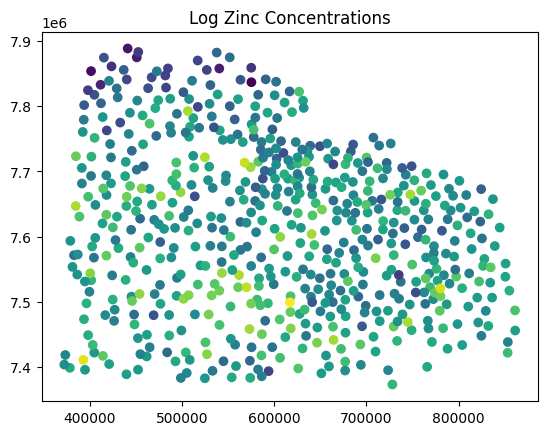

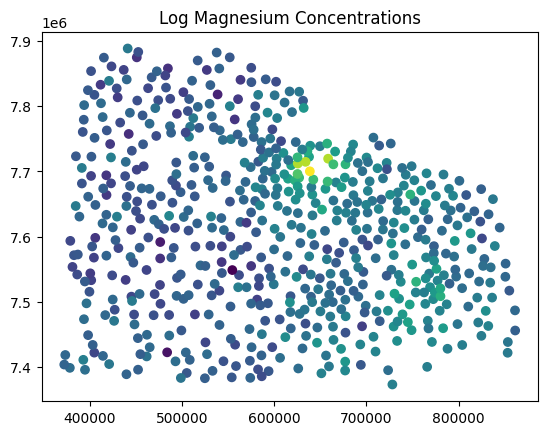

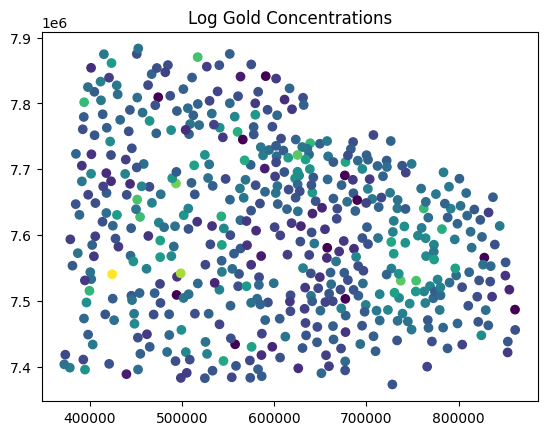

In [277]:
plt.scatter(moss.XCOO, moss.YCOO, c=np.log(moss.Ni))
plt.title("Log Nickle Concentrations")
plt.show()

plt.scatter(moss.XCOO, moss.YCOO, c=np.log(moss.Zn))
plt.title("Log Zinc Concentrations")
plt.show()

plt.scatter(moss.XCOO, moss.YCOO, c=np.log(moss.S))
plt.title("Log Sulfur Concentrations")
plt.show()

plt.scatter(moss.XCOO, moss.YCOO, c=np.log(moss.Au))
plt.title("Log Gold Concentrations")
plt.show()

In [37]:
np.isnan(x).mean()

np.float64(0.0)

In [278]:
from sklearn.decomposition import PCA
nc = 10
xt = ilr(x, eps=1e-5)

# Initialize PCA to retain 2 components
pca = PCA(n_components=nc)

# Fit PCA to the scaled data
pca.fit(xt)
xt = pca.transform(xt)

In [279]:
xt.shape

(594, 10)

In [280]:
M100KM = calculate_local_covariance(s, 100_000, xt)
M50KM = calculate_local_covariance(s, 50_000, xt)
M25KM = calculate_local_covariance(s, 25_000, xt)
M5KM = calculate_local_covariance(s, 5_000, xt)

M = np.stack((M100KM, M50KM, M25KM, M5KM), axis=0)

In [281]:
xt.shape, M.shape

((594, 10), (4, 10, 10))

In [282]:
G, rslts = qndiag(M, ortho=True)

In [283]:
np.allclose(G @ G.T, np.eye(nc))

True

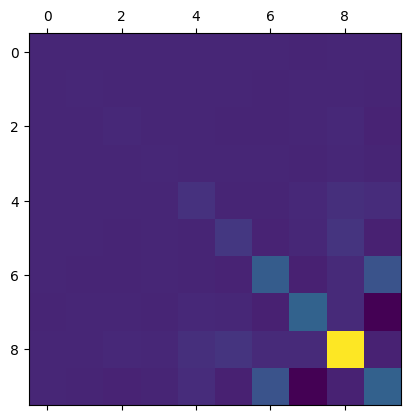

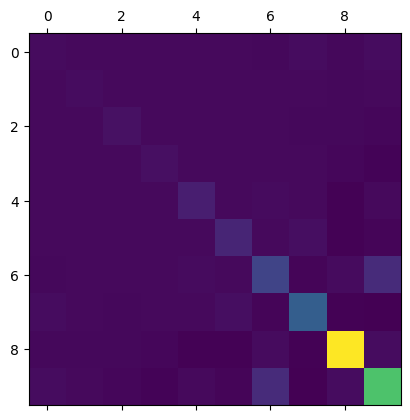

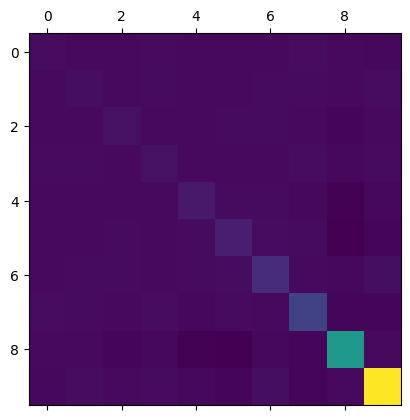

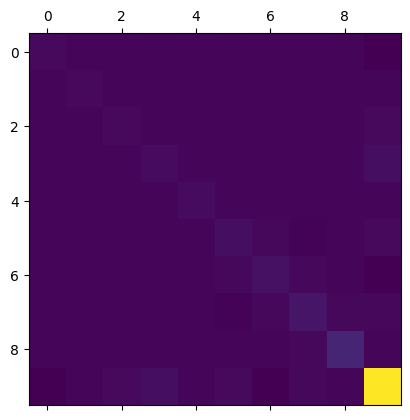

In [284]:
plt.matshow(G @ M100KM @ G.T)
plt.matshow(G @ M50KM @ G.T)
plt.matshow(G @ M25KM @ G.T)
plt.matshow(G @ M5KM @ G.T)

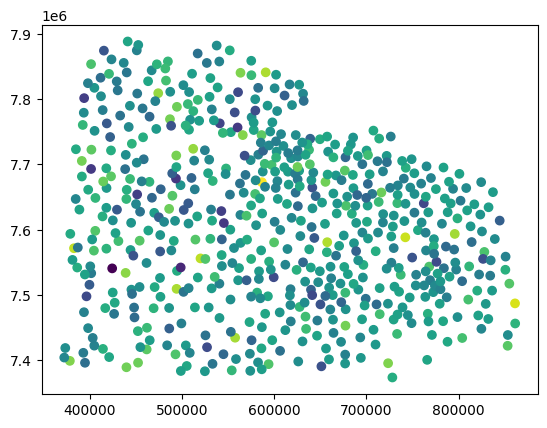

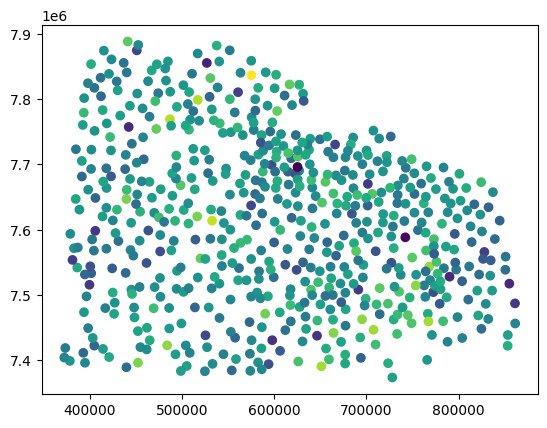

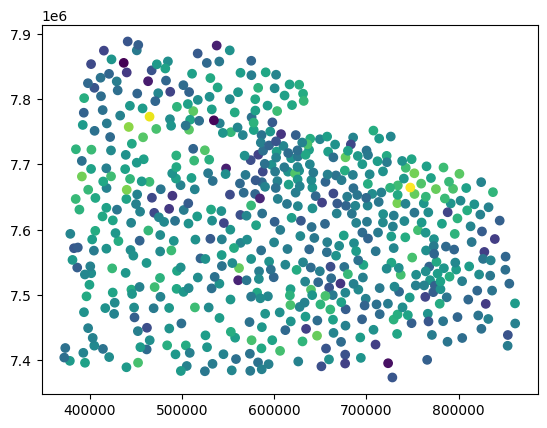

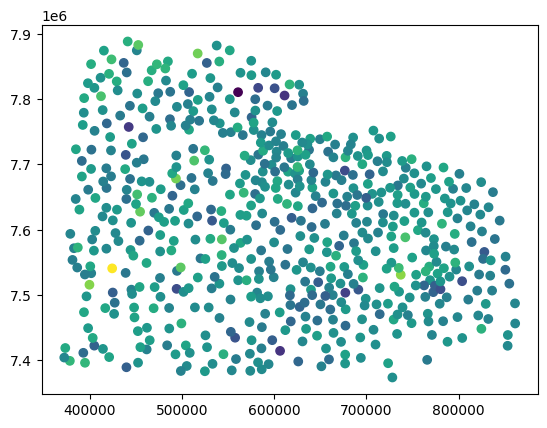

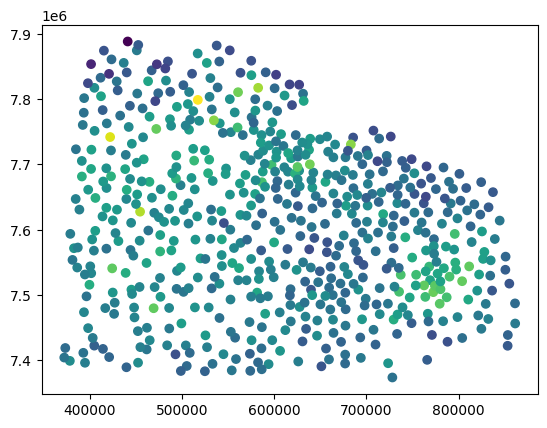

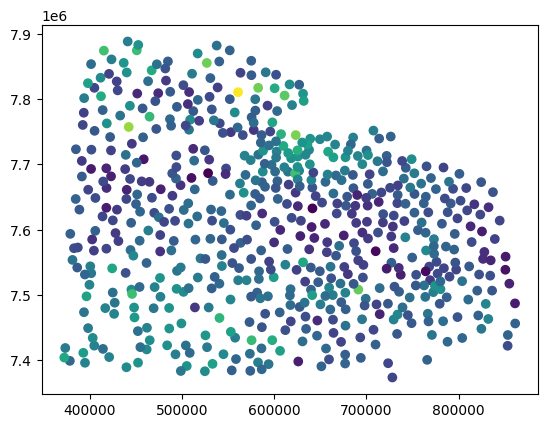

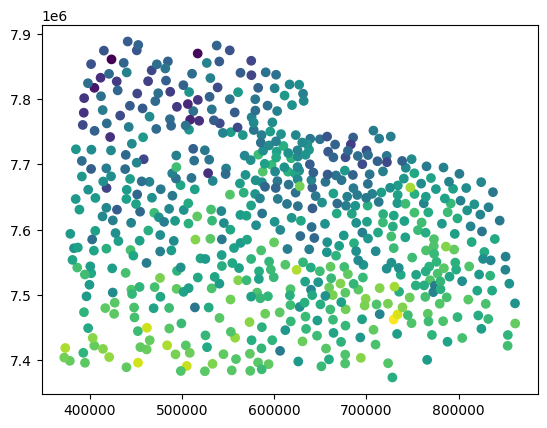

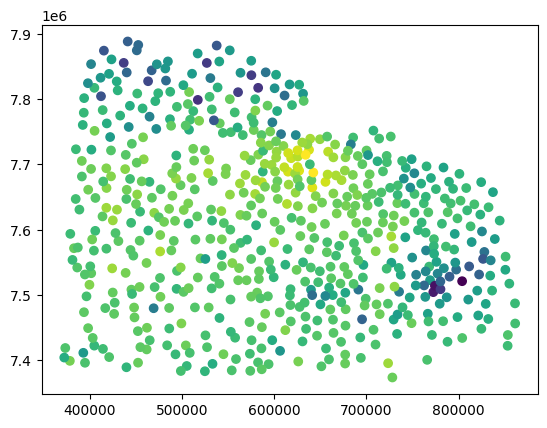

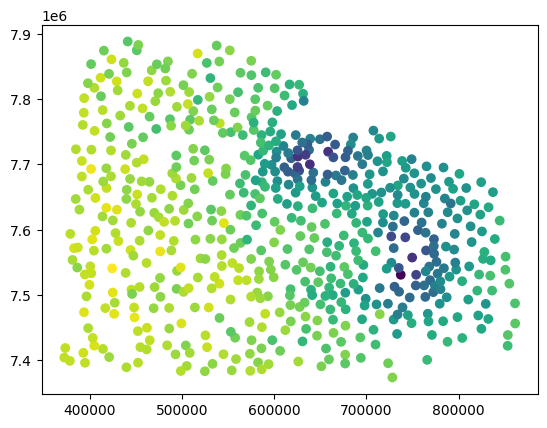

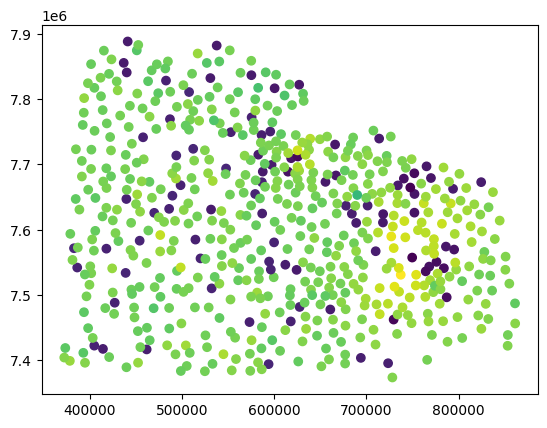

In [285]:
zt = G @ xt.T
for i in range(nc):
    plt.scatter(s.T[0], s.T[1], c = zt[i])
    plt.show()